In [1]:
import numpy as np
import pyFAI
from pyFAI.test.utilstest import UtilsTest
import fabio
from pyFAI.gui import jupyter
from pyFAI import units
from pyFAI.method_registry import Method, IntegrationMethod

import dioptas

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
import glob

'''
Detector Detector        Spline= None    PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m   PONI= 3.000000e-02, 3.000000e-02 m      rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm      Center: x=300.000, y=300.000 pix        Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
'''

# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Wed Feb 28 16:54:36 2024
poni_version = 2
detector = 'Detector'
detector_config = {"pixel1": 0.00017199999999999998, "pixel2": 0.00017199999999999998, "max_shape": None}
distance = 0.21131807888775977
poni1 = 0.09037558065194548
poni2 = 0.08404998444289956
rot1 = 0.0002369738519685619
rot2 = 0.0014384861374195596
rot3 = 0.0
wavelength = 4.0660000000000005e-11

polarization = 0.99
width = 2048
height = 2048
calibrant = 'LaB6'
transformation = {'rotate90': False,
                  'rotate270': False,
                  'flip_horizontal': False,
                  'flip_vertical': False}

cal_image_path = '../dataset/Sector16/40x41/calibration/CeO2_DMM30keV_400mm_20sec_PE_001.tif'
scan_image_path = glob.glob('../dataset/Sector16/40x41/DMM_Zr_0p66GPa/*.tif')

tif_cal_image = Image.open(cal_image_path)
tif_scan1 = Image.open(scan_image_path[0])
print(tif_cal_image.size, tif_scan1.size)
# tif_cal_image.resize((1000,1000)).show()
# tif_scan1.resize((1000,1000)).show()


(2048, 2048) (2048, 2048)


{'nRows': 2048, 'nColumns': 2048, 'nBits': 16, 'compression': False, 'compression_type': 1, 'imageDescription': '1/1', 'stripOffsets': [8], 'rowsPerStrip': 2048, 'stripByteCounts': [8388608], 'software': 'EPICS areaDetector', 'date': 'Unknown Date', 'colormap': None, 'sampleFormat': 1, 'photometricInterpretation': 1, 'model': ('Unknown',), 'info': {}}
Detector Detector	 Spline= None	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 4.066000e-11 m
SampleDetDist= 2.113181e-04 m	PONI= 1.761280e-01, 1.761280e-01 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 0.211 mm	Center: x=1024.000, y=1024.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.407Å
what is integrationMethod? <class 'type'>
what is integrationMethod.select_method? <class 'list'>
19
IntegrationMethod(2d int, no split, histogram, python)broken
IntegrationMethod(2d int, no split, histogram, cython)broken
IntegrationMethod(2d int, bbox split, histogram, cython)broken
IntegrationMethod(2d int, full split, histogr

<Axes: xlabel='Scattering vector $q$ ($nm^{-1}$)', ylabel='Azimuthal angle $\\chi$ ($^{o}$)'>

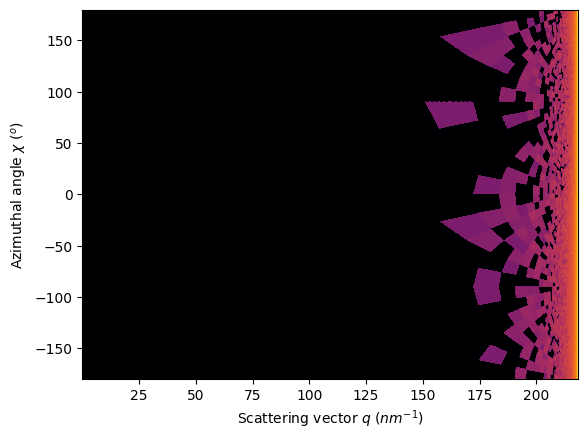

In [2]:
meta = fabio.open(scan_image_path[0]).header
img = fabio.open(scan_image_path[0]).data
img = np.resize(img,(width,height))
print(meta)

det = pyFAI.detector_factory("Detector", {"pixel1": detector_config['pixel1'],"pixel2": detector_config['pixel2']})
ai = pyFAI.load({"detector": det, "wavelength": wavelength})
ai.setFit2D(distance, width/2, height/2)

print(ai)
print('what is integrationMethod?', type(IntegrationMethod))
print('what is integrationMethod.select_method?', type(IntegrationMethod.select_method(dim=2)))
print(len(IntegrationMethod.select_method(dim=2)))

for m in IntegrationMethod.select_method(dim=2):
    print(m, end="")
    if m.algorithm=="histogram" and m.target is not None:
        print("OpenCL histogram skipped")
        continue
    try:
        regrouped = ai.integrate2d(data, npt_rad, npt_azim, unit="q_nm^-1")[0]
#         pyFAI.azimuthalIntegrator.AzimuthalIntegrator(
#             dist=1, poni1=0, poni2=0, rot1=0, rot2=0, rot3=0, pixel1=None, pixel2=None, splineFile=None, \
#             detector=None, wavelength=None, orientation=0
#         )
        res = ai.integrate2d(img, width/2, height/2, method=m, unit="q_nm^-1")          ##("qx_nm^-1","qy_nm^-1"))
    except:
        print("broken")
    else:
        print(f"{res[1].min():.2f}<qx<{res[1].max():.2f}, \
        {res[2].min():.2f}<qy<{res[2].max():.2f} <I>={np.nanmean(res[0]):.2f} ± {np.nanstd(res[0]):.2f}")

m = IntegrationMethod.select_method(dim=2, split="full", algo="CSR")[0]
print('m', m)

print(type(img))
print(img.shape)
ai.reset()
res = ai.integrate2d(img, width, height, method=m)  #, unit=("qx_nm^-1", "qy_nm^-1"))

jupyter.plot2d(res)

In [3]:
ai._cached_array.keys()

dict_keys(['cos_incidence', 'solid_angle#3.0_crc', 'solid_angle#3.0', 'q_corner'])

In [4]:
# Now with a new space: 2thx, 2thy:
tthx = pyFAI.units.register_radial_unit("tthx_deg",
                                        scale=180.0/np.pi,
                                        label=r"$2\theta$ angle along x ($^{o}$)",
                                        formula="arctan2(x,z)",
                                        short_name="2thx",
                                        unit_symbol="^{o}",
                                        positive=False)
tthy = pyFAI.units.register_azimuthal_unit("tthy_deg",
                                        scale=180.0/np.pi,
                                        label=r"$2\theta$ angle along y ($^{o}$)",
                                        formula="arctan2(y,z)",
                                        short_name="2thy",
                                        unit_symbol="^{o}",
                                        positive=False)
res = ai.integrate2d(img, 400,400, method=m, unit=("tthx_deg", "tthy_deg"))
jupyter.plot2d(res)
pass

TypeError: register_radial_unit() got an unexpected keyword argument 'positive'